# Kaggle


Some thoughts on this [competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview) about house's price. This model has a serious problem, as we are averaging over categorial classes as if they were independent. Nevertheless, the results are satisfatory.

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import RidgeCV
from sklearn import preprocessing

In [3]:
import matplotlib.pylab as plt

In [34]:
import joblib

In [4]:
df = pd.read_csv('train.csv')

Fill all missing values on the data frame with consistent values. For categorial columns we use the most commom value and for numerical ones we use the mean of the values present. We could improve it further by restricting the most commom values/means over a subset of the data (like over Neighborhood).

In [5]:
values_to_fill = dict()

for col in df.columns:
    if df.dtypes[col] != object:
        values_to_fill[col] = int(df[col].mean())
    else:
        x = df[col].value_counts()
        values_to_fill[col] = np.array(x[x == x.max()].index)[0]
        
df = df.fillna(value=values_to_fill)

We remove, in a naïve manner, some outliers. This is a point that can receive a lot of improvements.

In [6]:
condition = (df['SalePrice'] < 500000) & (df['LotArea'] < 50000)
df = df.loc[condition, :]

Change the _PoolArea_ column into a boolean flag.

In [7]:
df['has_pool'] = round(df['PoolArea']/(0.1 + df['PoolArea']),2)

Our feature engineering is done here. Basically we compute the mean, max and min of the sale price over many features and pass them into the models. This calculation is done over the training set and them used, by means of left joins, into the test and validation sets.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df, df['SalePrice'], test_size = 0.1)

group_columns = [
                'Neighborhood',
                'MSSubClass',
                'MSZoning',
                'Fence',
                'RoofStyle',
                'has_pool',
                'PavedDrive',
                'SaleType',
                'LotConfig',
                'LandSlope',
                'LandContour',
                'SaleCondition',
                'KitchenQual'
                ]

means_df = dict()
cols_means = list()

for col in group_columns:
    temp = X_train.groupby([col])['SalePrice'].agg([np.mean, np.max, np.min]).reset_index()
    cols_to_rename = {'mean': f'{col}_mean', 'amax': f'{col}_max', 'amin': f'{col}_min'}
    
    means_df[col] = temp.rename(columns=cols_to_rename)
    cols_means += list(cols_to_rename.values()) 

Merge all the averages computed earlier on the train and test datasets

In [9]:
X_train = X_train.drop(labels=['SalePrice'], axis='columns')
for col, x in means_df.items():
    X_train = X_train.merge(x, on = [col], how = 'left')
    
X_test = X_test.drop(labels=['SalePrice'], axis='columns')
for col, x in means_df.items():
    X_test = X_test.merge(x, on = [col], how = 'left')

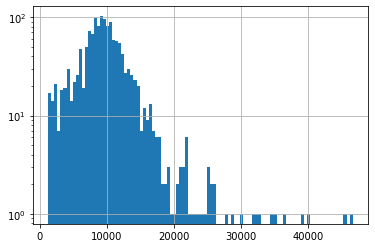

In [10]:
df['LotArea'].hist(bins = 100, log=True)

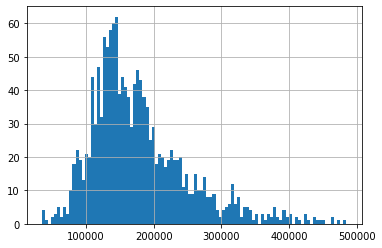

In [11]:
df['SalePrice'].hist(bins = 100)

In [12]:
df.shape

(1441, 82)

In [13]:
X_train.shape

(1296, 120)

In [14]:
X_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,LandSlope_min,LandContour_mean,LandContour_max,LandContour_min,SaleCondition_mean,SaleCondition_max,SaleCondition_min,KitchenQual_mean,KitchenQual_max,KitchenQual_min
0,1334,50,RM,60.0,7200,Pave,Grvl,Reg,Lvl,AllPub,...,34900,177868.852641,485000,34900,173042.46263,475000,39300,209992.168856,438780,79000
1,668,20,RL,65.0,8125,Pave,Grvl,Reg,Lvl,AllPub,...,34900,177868.852641,485000,34900,173042.46263,475000,39300,209992.168856,438780,79000
2,788,60,RL,76.0,10142,Pave,Grvl,IR1,Lvl,AllPub,...,34900,177868.852641,485000,34900,173042.46263,475000,39300,209992.168856,438780,79000
3,852,120,RL,70.0,3196,Pave,Grvl,Reg,Lvl,AllPub,...,34900,177868.852641,485000,34900,173042.46263,475000,39300,209992.168856,438780,79000
4,986,190,RL,68.0,10880,Pave,Grvl,Reg,Lvl,AllPub,...,34900,177868.852641,485000,34900,173042.46263,475000,39300,139248.030960,359100,34900


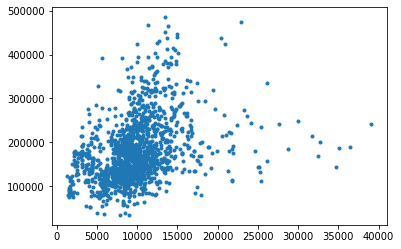

In [15]:
plt.plot(df.loc[df['LotArea'] < 40000, 'LotArea'], df.loc[df['LotArea'] < 40000, 'SalePrice'], '.')

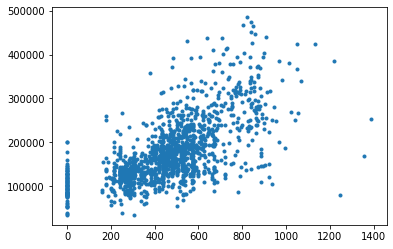

In [16]:
plt.plot(df.loc[df['GarageArea'] < 100000, 'GarageArea'], df.loc[df['GarageArea'] < 100000, 'SalePrice'], '.')

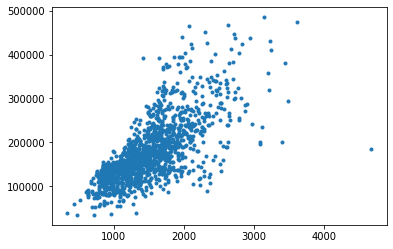

In [17]:
plt.plot(df.loc[df['GrLivArea'] < 100000, 'GrLivArea'], df.loc[df['GrLivArea'] < 100000, 'SalePrice'], '.')

In [18]:
columns = ['LotArea', 'GrLivArea', 'GarageArea', 'GarageCars',  'WoodDeckSF',  'TotRmsAbvGrd',
           '1stFlrSF', 'KitchenAbvGr', 'BedroomAbvGr', 'OpenPorchSF', 'MoSold', 'ScreenPorch',
           'Fireplaces', 'OverallQual', 'OverallCond', 'FullBath', 'HalfBath', 'EnclosedPorch', 'BsmtFinSF1',
           'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'TotalBsmtSF', 'LowQualFinSF']

columns = columns + cols_means

scaler = preprocessing.StandardScaler().fit(X_train[columns])

## Models
Here we fit our models

### Linear regression

In [19]:
model = LinearRegression()
model.fit(scaler.transform(X_train[columns]), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
model_predictions = model.predict(scaler.transform(X_test[columns]))
model.score(scaler.transform(X_test[columns]), y_test)

0.9006034886787215

### Ridge regression

In [21]:
model2 = RidgeCV(cv=5, alphas=(0.01, 0.1, 0.25, 0.5, 1.0, 5.0, 10.0, 50), scoring='neg_root_mean_squared_error')
model2.fit(scaler.transform(X_train[columns]), y_train)

RidgeCV(alphas=array([1.0e-02, 1.0e-01, 2.5e-01, 5.0e-01, 1.0e+00, 5.0e+00, 1.0e+01,
       5.0e+01]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring='neg_root_mean_squared_error', store_cv_values=False)

In [22]:
model2.get_params()

{'alphas': array([1.0e-02, 1.0e-01, 2.5e-01, 5.0e-01, 1.0e+00, 5.0e+00, 1.0e+01,
        5.0e+01]),
 'cv': 5,
 'fit_intercept': True,
 'gcv_mode': None,
 'normalize': False,
 'scoring': 'neg_root_mean_squared_error',
 'store_cv_values': False}

In [23]:
model_predictions2 = model2.predict(scaler.transform(X_test[columns]))
model2.score(scaler.transform(X_test[columns]), y_test)

0.8934277621531277

### Gradient boosting

In [24]:
model3 = GradientBoostingRegressor(n_estimators=400, max_depth=2)
model3.fit(scaler.transform(X_train[columns]), y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=400,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [25]:
scores = cross_val_score(model3, scaler.transform(X_train[columns]), y_train, cv=5)
scores, scores.mean()

(array([0.91140575, 0.90078261, 0.915098  , 0.79449231, 0.90682893]),
 0.8857215201682382)

In [26]:
model_predictions3 = model3.predict(scaler.transform(X_test[columns]))
model3.score(scaler.transform(X_test[columns]), y_test)

0.928429332756393

Does some plots to illustrate the predictions of the linear and the gradient boosting models

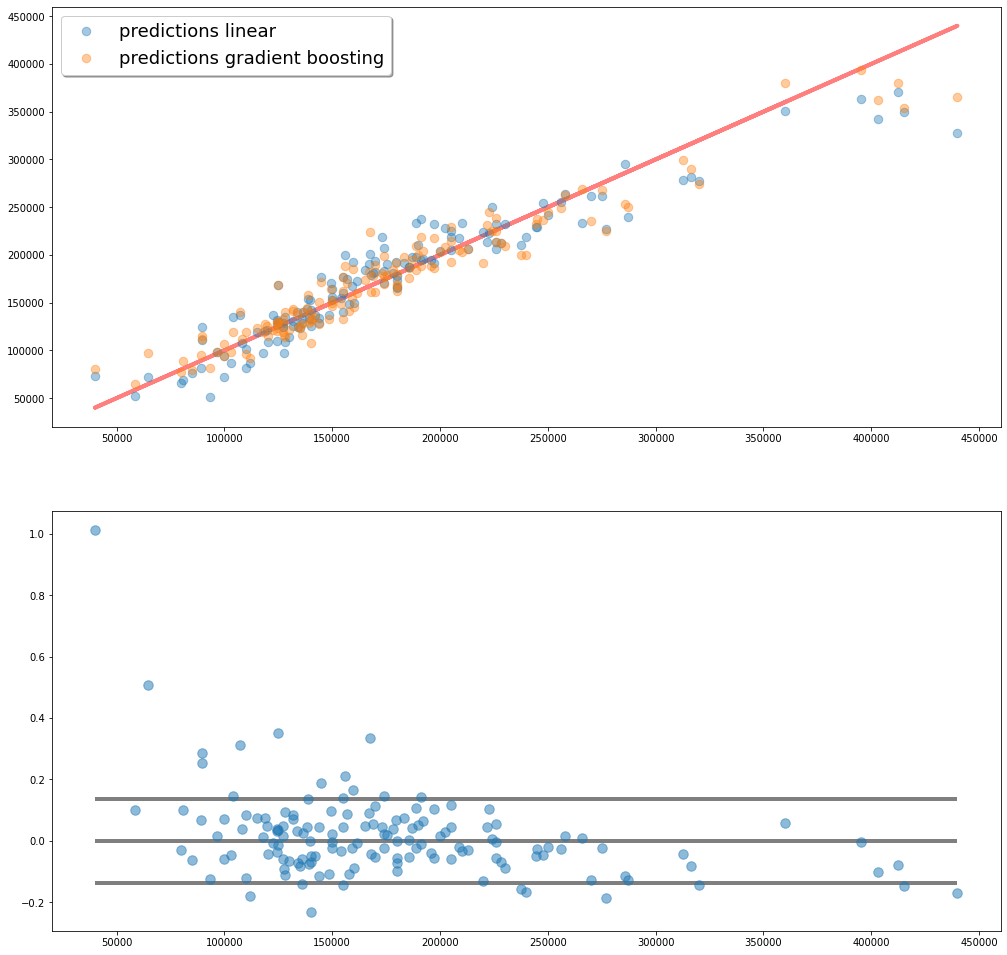

In [27]:
fig, ax = plt.subplots(figsize=(17,17), nrows=2, ncols=1)

ax[0].plot(y_test, y_test, 'r-', lw=4, alpha=0.5)
ax[0].plot(y_test, model_predictions, '.', ms=17, alpha=0.4, label='predictions linear')
ax[0].plot(y_test, model_predictions3, '.', ms=17, alpha=0.4, label='predictions gradient boosting')
ax[0].legend(fontsize=18, shadow=True, fancybox=True)

error_std = np.std((model_predictions3 - y_test)/y_test)

ax[1].hlines(y=0, xmin=min(y_test), xmax=max(y_test), lw=4, alpha=0.5)
ax[1].hlines(y=error_std, xmin = min(y_test), xmax = max(y_test), lw=4, alpha=0.5)
ax[1].hlines(y=-error_std, xmin = min(y_test), xmax = max(y_test), lw=4, alpha=0.5)
ax[1].plot(y_test, (model_predictions3 - y_test)/y_test, '.', ms = 19, alpha = 0.5)

In [28]:
mean_squared_error(np.log(y_test), np.log(abs(model_predictions2)), squared=False)

0.1393844854425037

Now we do the predictions on the kaggle validation data set.

In [29]:
df_test = pd.read_csv('test.csv')
df_test = df_test.fillna(value=values_to_fill)
df_test['has_pool'] = round(df_test['PoolArea']/(0.1 + df_test['PoolArea']),2)

In [30]:
ids = df_test['Id']

In [31]:
for col, x in means_df.items():
    df_test = df_test.merge(x, on = [col], how = 'left')

df_test = df_test.loc[:, columns].fillna(X_train['Neighborhood_mean'].mean())

In [32]:
predictions = model3.predict(scaler.transform(df_test))
output = pd.DataFrame(list(zip(ids, predictions))).rename({0: 'Id', 1: 'SalePrice'}, axis='columns')
output.to_csv('submission.csv', index=False)

In [33]:
output

,Id,SalePrice
0,1461,122909.871187
1,1462,165737.612194
2,1463,189823.252681
3,1464,190334.331951
4,1465,194881.866119
...,...,...
1454,2915,83129.359185
1455,2916,83602.197768
1456,2917,182724.845108
1457,2918,122015.087456


### Save the trained model on disk

In [35]:
filename = 'house_pricing_gradient_boosting.model'
joblib.dump(model3, filename)

['house_pricing_gradient_boosting.model']